In [7]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

In [ ]:
# Circuito para medir V

def sin(h,k):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)


# Define the parameters

def qc_V(h,k):

    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*alpha,qr[0])
    qc.cx(qr[0],qr[1])
    qc.barrier()

    # Alice's projective measurement
    qc.h(qr[0])
    qc.barrier()

    #Bob's conditional operation
    phi=0.5*np.arcsin(sin(k,h))
    qc.cry(-2*phi,qr[0],qr[1])

    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    #Measurement of the interaction V
    qc.h(qr[1])
    qc.measure_all()

    return qc


In [ ]:
# Circuito para medir H

def sin(h,k):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2)

# Define the parameters

def qc_H(h,k):

    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)

    #Prepare the ground state
    alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*alpha,qr[0])
    qc.cx(qr[0],qr[1])
    qc.barrier()

    # Alice's projective measurement
    qc.h(qr[0])
    qc.barrier()

    #Bob's conditional operation
    phi=0.5*np.arcsin(sin(k,h))
    qc.cry(-2*phi,qr[0],qr[1])

    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # measurement of Bob's Z term
    qc.measure_all()

    return qc

In [13]:
# Simular circuito V

from qiskit_aer import AerSimulator
simulator = AerSimulator()

n_shots = 100000
h = 1; k = 1.5;
qc = qc_V(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)
jobA_sim = sampler().run([qc_A], shots=n_shots)

In [14]:
# Simular circuito H

from qiskit_aer import AerSimulator
simulator = AerSimulator()

n_shots = 100000
h = 1; k = 1.5;
qc = qc_H(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)
jobB_sim = sampler().run([qc_B], shots=n_shots)

Exact E_A 0.5547001962252291
Alice's local energy 0.5576601962252291 STD is 0.0031622638068320615
Interacting energy V -0.4136091169864687 STD is 0.009486807449505865


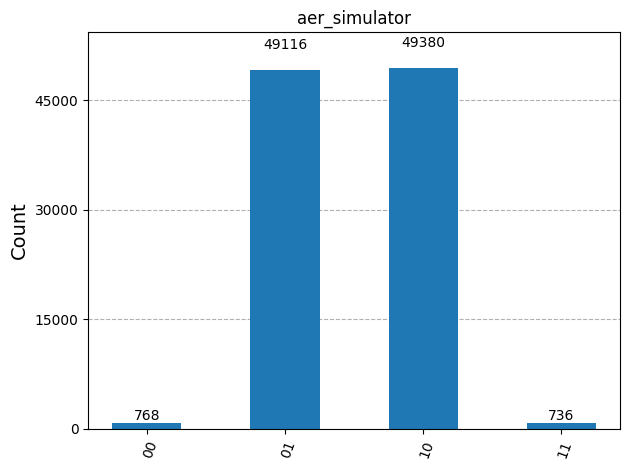

In [ ]:
# Results from simulated circuit V

result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()
ene_A=(h**2)/(np.sqrt(h**2+k**2))
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))

error_A=[]
error_V=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Exact E_A",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy V",ene_V,"STD is",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')

Exact E_A 0.5547001962252291
Alice's local energy 0.5583601962252291 STD is 0.0031622564797941354
Bob's local energy 0.3064201962252292 STD is 0.003063261401839549


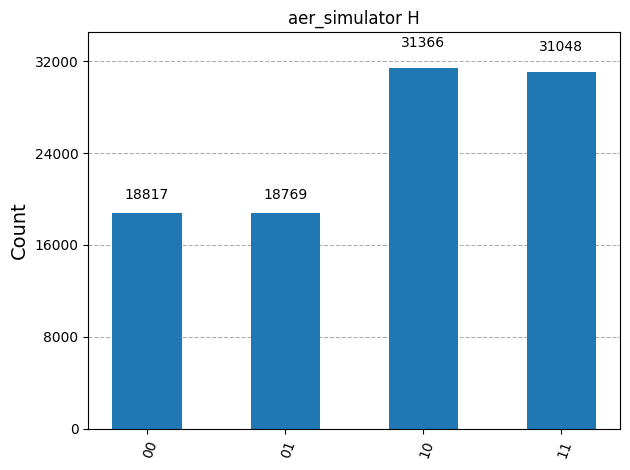

In [ ]:
# Results from simulated circuit H

result= jobB_sim.result()[0]
counts = result.data.meas.get_counts()
ene_A=(h**2)/(np.sqrt(h**2+k**2))
ene_B=(h**2)/(np.sqrt(h**2+k**2))

error_A=[]
error_B=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

print("Exact E_A",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy",ene_B,"STD is",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")

In [ ]:
# Get backend

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(operational=True)

props = backend.properties()

def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Backend = {6}\n"
          "Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz,
              backend.name))

describe_qubit(0, props)

Backend = ibm_brisbane
Qubit 0 has a 
  - T1 time of 237.36364020705798 microseconds
  - T2 time of 54.13592945185757 microseconds
  - U2 gate error of 9.67188067665e-05
  - U2 gate duration of 59.99999999999999 nanoseconds
  - resonant frequency of 4.721909196897689 GHz


In [ ]:
# Run job in IBM Backend

from qiskit_ibm_runtime import Batch, SamplerV2 as sampler

variables = [(1,0.2),(1,0.5),(1,1),(1.5,1)]

with Batch(backend=backend):
    n_shots = 5000

    for variable in variables:
        h = variable[0]
        k = variable[1]

        V_circuit = qc_V(h,k)
        H_circuit = qc_H(h,k)

        qc_A= transpile(V_circuit, backend=backend, optimization_level=3)
        job_A = sampler().run([(qc_A)], shots=n_shots)
        print(job_A.job_id())

        qc_B = transpile(H_circuit, backend=backend, optimization_level=3)
        job_B = sampler().run([(qc_B)], shots=n_shots)
        print(job_B.job_id())

cyemjfs9b62g008jkw20
cyemjj29b62g008jkw30
cyemjma9b62g008jkw3g


qiskit_runtime_service.check_pending_jobs:WARNING:2025-01-31 18:06:16,506: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cyemjfs9b62g008jkw20', 'sampler')> to finish before submitting the next one.


cyemjsv7v8tg008hbbhg
cyemjwb7v8tg008hbbjg
cyemjybcw2k0008r6k60
cyemk04nrmz00086ht0g
cyemk2wrta1g0088363g


Exact E_A 1.2480754415067656
Alice's local energy 1.2690754415067655 STD is 0.033537732481490154
Interacting energy V -0.5125996075495418 STD is 0.044697002136608655


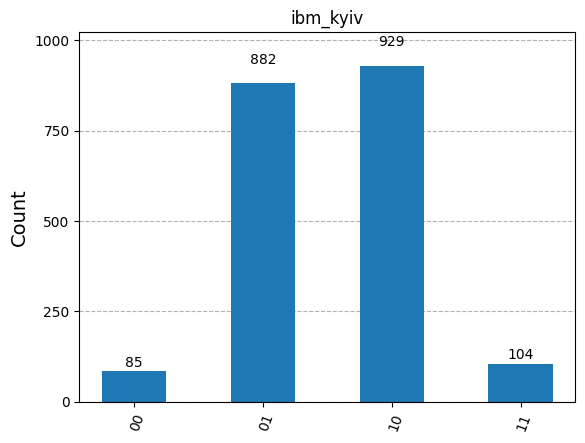

In [ ]:
# Show results for circuit V

jobA = service.job('cybwydh9b62g008j8xk0')
result = jobA.result()[0]
counts = result.data.meas.get_counts()

k = 1
h = 1.5

ene_A=(h**2)/(np.sqrt(h**2+k**2))
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))

error_A=[]
error_V=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Exact E_A",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy V",ene_V,"STD is",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='ibm_kyiv V')

Exact E_A 1.2480754415067656
Bob's local energy 0.3675754415067656 STD is 0.027154371195076497


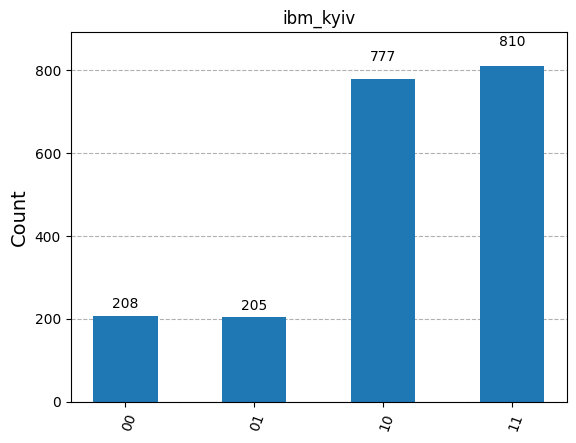

In [ ]:
jobB = service.job('cybwyf17v8tg008g0a70')
result = jobB.result()[0]
counts = result.data.meas.get_counts()

k = 1
h = 1.5

ene_A=(h**2)/(np.sqrt(h**2+k**2))
ene_B=(h**2)/(np.sqrt(h**2+k**2))

error_A=[]
error_B=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

print("Exact E_A",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy",ene_A,"STD is",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy",ene_B,"STD is",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title='ibm_kyiv H')

In [ ]:
cyemjfs9b62g008jkw20
cyemjj29b62g008jkw30
cyemjma9b62g008jkw3g
cyemjsv7v8tg008hbbhg
cyemjwb7v8tg008hbbjg
cyemjybcw2k0008r6k60
cyemk04nrmz00086ht0g
cyemk2wrta1g0088363g